In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot  as plt

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_feature(booster, figsize):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info





sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)

In [3]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv').set_index('ID')


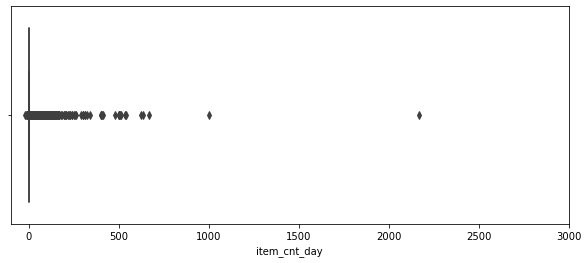

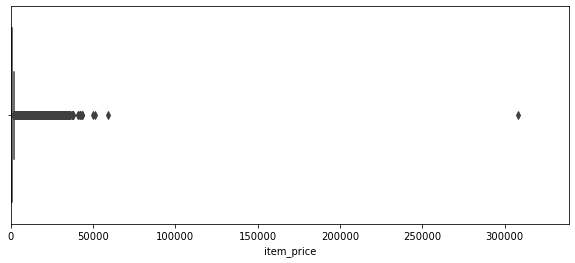

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


In [5]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]


In [6]:
median = train[(train.shop_id==32) &(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [17]:
median

1874.0

In [17]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] =57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58


In [18]:
train.loc[train.shop_id == 0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [8]:
train.loc[train['shop_id']==0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
37589,12.01.2013,0,0,11059,73.0,1.0
37590,22.01.2013,0,0,11059,73.0,1.0
37591,26.01.2013,0,0,11059,73.0,1.0
37592,12.01.2013,0,0,11347,170.0,1.0
37593,22.01.2013,0,0,11347,170.0,1.0
...,...,...,...,...,...,...
183257,22.02.2013,1,0,13460,1228.0,2.0
183258,21.02.2013,1,0,13460,1228.0,1.0
183259,20.02.2013,1,0,13460,1228.0,1.0
183260,17.02.2013,1,0,13460,1228.0,1.0


In [16]:
test.loc[test.shop_id == 58]

,shop_id,item_id
ID,,
142800,58,5037
142801,58,5320
142802,58,5233
142803,58,5232
142804,58,5268
...,...,...
147895,58,18454
147896,58,16188
147897,58,15757


In [12]:
test.loc[test['shop_id'] == 0]

,shop_id,item_id
ID,,


In [20]:
product([1])

In [21]:
train.loc[train.shop_id == 10]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
53564,26.01.2013,0,10,6000,190.0,1.0
53565,12.01.2013,0,10,6007,180.0,1.0
53566,08.01.2013,0,10,6093,200.0,1.0
53567,12.01.2013,0,10,6093,200.0,1.0
53568,13.01.2013,0,10,6095,1321.0,1.0
...,...,...,...,...,...,...
2919918,03.10.2015,33,10,7893,2465.0,1.0
2919919,03.10.2015,33,10,7879,2209.0,1.0
2919920,20.10.2015,33,10,7942,3418.0,1.0
2919921,24.10.2015,33,10,7933,822.0,1.0


In [22]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [23]:
shops[:60]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [25]:
shops['shop_name'].str.split(' ').map(lambda x: x[0])

0              !Якутск
1              !Якутск
2               Адыгея
3             Балашиха
4             Волжский
5              Вологда
6              Воронеж
7              Воронеж
8              Воронеж
9             Выездная
10           Жуковский
11           Жуковский
12    Интернет-магазин
13              Казань
14              Казань
15              Калуга
16             Коломна
17          Красноярск
18          Красноярск
19               Курск
20              Москва
21              Москва
22              Москва
23              Москва
24              Москва
25              Москва
26              Москва
27              Москва
28              Москва
29              Москва
30              Москва
31              Москва
32              Москва
33              Мытищи
34          Н.Новгород
35          Н.Новгород
36         Новосибирск
37         Новосибирск
38                Омск
39        РостовНаДону
40        РостовНаДону
41        РостовНаДону
42                 СПб
43         

In [26]:
cats

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9
